In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression,kalman_filter, make_FXHedge
from hc_graph import hc_stock

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


### Load Data

In [4]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']
EUR_rate = pd.read_csv(r"financial_data/EUR_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

#fx
EUR_USD_fx = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['EUR/USD']
GBP_USD_fx = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['GBP/USD']

In [5]:
guru_er = pd.read_csv(r"financial_data/guru_ls_tracking.csv", index_col=0,parse_dates=True, \
                   dayfirst=True)[['EU_BNPILSNE']]

guru_fx_er = make_FXHedge(guru_er,EUR_USD_fx)

In [25]:
#bnp_all_EU = pd.read_csv(r"financial_data/guru_ls_tracking.csv", index_col=0,parse_dates=True,\
#                      dayfirst=True)[["EU_BNPIPMEE","EU_BNPIPVEE","EU_BNPIPQEE","EU_BNPIPLEE"]]

bnp_all_EU = pd.read_csv(r"financial_data/guru_long_tracking.csv", index_col=0,parse_dates=True,\
                      dayfirst=True)[["EU_BNPIFME","EU_BNPIFVE","EU_BNPIFQE","EU_BNPIFLVE"]]

bnp_all_er_EU = make_ER(bnp_all_EU,EUR_rate)
bnp_all_fx_EU = make_FXHedge(bnp_all_er_EU,EUR_USD_fx)

bnp_all_US = pd.read_csv(r"financial_data/guru_ls_tracking.csv", index_col=0,parse_dates=True,\
                      dayfirst=True)[["US_BNPIPMUE","US_BNPIPVUE","US_BNPIPQUE","US_BNPIPLUE"]]


bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU',
                                                                                                 "BNPIFUS"]]
bnp = bnp.join(bnp_all_fx_EU,how="inner").join(bnp_all_US,how="inner")
bnp = bnp/bnp.iloc[0]
bnp.head()

,BNPIFEU,BNPIFUS,EU_BNPIFME,EU_BNPIFVE,EU_BNPIFQE,EU_BNPIFLVE,US_BNPIPMUE,US_BNPIPVUE,US_BNPIPQUE,US_BNPIPLUE
2003-12-31,1,1,1,1,1,1,1,1,1,1
2004-01-01,1,1,1.00013,1.0032,1.00249,1.00034,1,1,1,1
2004-01-02,1.01435,0.999,1.00171,1.00603,1.00641,0.999773,0.998294,1.0021,0.997998,0.996399
2004-01-05,1.01671,1.01137,0.99865,1.00721,1.00365,1.00409,0.997992,1.0028,1.0018,0.9989
2004-01-06,1.01688,1.01331,0.994748,1.00392,0.997675,1.00253,1.00141,1.0048,1.0025,0.996899


In [26]:
prices_all = bnp.ffill().dropna()
returns_all = prices_all.resample('1D').first().pct_change().dropna()
guru_returns = guru_fx_er.resample('1D').first().pct_change().dropna()

In [27]:
returns_all.head()

,BNPIFEU,BNPIFUS,EU_BNPIFME,EU_BNPIFVE,EU_BNPIFQE,EU_BNPIFLVE,US_BNPIPMUE,US_BNPIPVUE,US_BNPIPQUE,US_BNPIPLUE
2004-01-01,0.000000,0.000000,0.000130,0.003199,0.002490,0.000335,0.000000,0.000000,0.000000,0.000000
2004-01-02,0.014352,-0.001000,0.001577,0.002822,0.003915,-0.000562,-0.001706,0.002101,-0.002002,-0.003601
2004-01-05,0.002323,0.012381,-0.003052,0.001170,-0.002747,0.004322,-0.000302,0.000699,0.003812,0.002510
2004-01-06,0.000169,0.001924,-0.003907,-0.003260,-0.005953,-0.001554,0.003420,0.001996,0.000700,-0.002003
2004-01-07,-0.008817,0.002560,-0.002718,-0.001139,-0.001516,-0.001924,-0.000702,-0.001295,-0.003396,-0.003612


In [28]:
size = 60
freq = 5

df_weight_ols = ols_regression(guru_returns, returns_all, size, freq)

prices_for_track_ols = prices_all.loc[df_weight_ols.index[0]:]
replication_ols = make_track(prices_for_track_ols, df_weight_ols)

df_res = guru_fx_er.loc[replication_ols.index]
df_res["OLS all"] = replication_ols

In [29]:
%%time
for nu in [2,4,6,8]:
    df_weight_kalman = kalman_filter(guru_returns, returns_all,freq, sigma_weight=nu*0.1 , sigma_return=0.1)\
                    .loc[df_weight_ols.index[0]:]

    prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]
    replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_res.index[0]:]
    df_res["Kalman {}".format(nu)] = replication_kalman

CPU times: user 17.3 s, sys: 81.7 ms, total: 17.4 s
Wall time: 17.6 s


In [30]:
df_res = df_res/df_res.iloc[0]

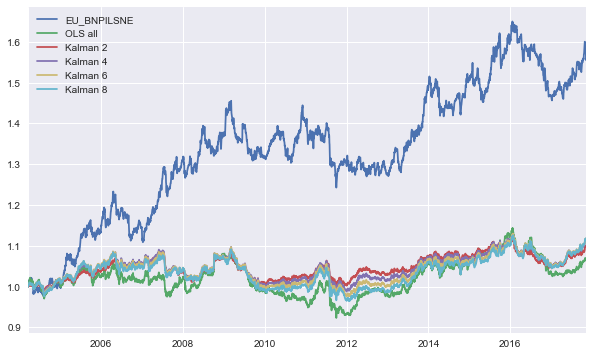

In [31]:
df_res.plot(figsize=(10,6))

In [32]:
Returns = df_res.pct_change().dropna()
Returns_repl = Returns.drop("EU_BNPILSNE", axis=1)
Returns_guru = Returns["EU_BNPILSNE"]

df_correl = Returns.corr(method='pearson')
df_correl

,EU_BNPILSNE,OLS all,Kalman 2,Kalman 4,Kalman 6,Kalman 8
EU_BNPILSNE,1.000000,0.452173,0.449455,0.482753,0.491135,0.492026
OLS all,0.452173,1.000000,0.800782,0.862210,0.883502,0.891502
Kalman 2,0.449455,0.800782,1.000000,0.970776,0.933774,0.901901
Kalman 4,0.482753,0.862210,0.970776,1.000000,0.990853,0.974108
Kalman 6,0.491135,0.883502,0.933774,0.990853,1.000000,0.995422
Kalman 8,0.492026,0.891502,0.901901,0.974108,0.995422,1.000000


In [33]:
df_stats = pd.DataFrame(index=df_res.drop("EU_BNPILSNE",axis=1).columns)
df_stats["correl"] = df_correl.loc["EU_BNPILSNE"].drop("EU_BNPILSNE")
df_stats["TE"] = (Returns_repl.T - Returns_guru.values).std(axis=1)
df_stats['$R^2$'] = 1 - (Returns_repl.T - Returns_guru.values).var(axis=1) / Returns_guru.values.var()

df_stats

,correl,TE,$R^2$
OLS all,0.452173,0.003501,0.130409
Kalman 2,0.449455,0.003360,0.199144
Kalman 4,0.482753,0.003307,0.224002
Kalman 6,0.491135,0.003302,0.226277
Kalman 8,0.492026,0.003313,0.220964


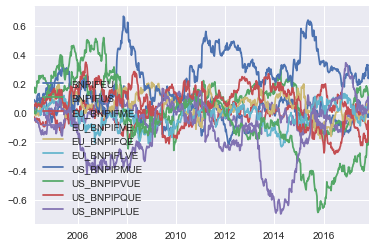

In [34]:
df_weight_kalman.plot()